In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.data as tfd
import tensorflow.keras as keras

import tensorflow_datasets as tfds

from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.layouts import grid, row

from image_plotter import show_image, show_images, show_image_probs

In [2]:
output_notebook()
np.set_printoptions(precision=2)

Loading BokehJS ...

# Explore Data

In [3]:
mnist, mnist_info = tfds.load("mnist", data_dir="/data", with_info=True)
mnist_info

W0818 14:57:16.325786 4607083968 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [4]:
classes = mnist_info.features["label"].names
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [5]:
images = []
label_idxs = []
for elem in mnist["train"].take(10):
    images.append(elem["image"])
    label_idxs.append(elem["label"])

In [6]:
images[0].shape

TensorShape([28, 28, 1])

The channel dim of 1 will not work too well with the image plotter, which expects dimensions to HxW or HxWxC. 

In [7]:
images = [image.numpy().squeeze() for image in images]
images[0].shape

(28, 28)

In [8]:
show_images(images, label_idxs=label_idxs, classes=classes, height=100, width=100)

In [19]:
print(np.min(images[0]), np.max(images[0]))

0 255


In [20]:
images[0].dtype

dtype('uint8')

# Split Dataset

In [16]:
test_mnist = tfds.load("mnist", data_dir="/data", split=tfds.Split.TEST)

In [17]:
first_80pct = tfds.Split.TRAIN.subsplit(tfds.percent[:80])
train_mnist = tfds.load("mnist", data_dir="/data", split=first_80pct)

last_20pct = tfds.Split.TRAIN.subsplit(tfds.percent[-20:])
val_mnist = tfds.load("mnist", data_dir="/data", split=last_20pct)

# Data Pipeline

In [21]:
def to_tpl(elem):
    return elem["image"], elem["label"]

def rescale(image, label):
    return image/255, label

train_ds = train_mnist.map(to_tpl)
train_ds = train_ds.map(rescale)

val_ds = val_mnist.map(to_tpl)
val_ds = val_ds.map(rescale)

test_ds = test_mnist.map(to_tpl)
test_ds = test_ds.map(rescale)

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER = 512

# Build Model

In [23]:
input_ = layers.Input(shape=(28,28,1))
x = layers.Conv2D(32, (3, 3), activation="relu")(input_)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
output = layers.Dense(10, activation="softmax")(x)
model = keras.Model(input_, output)

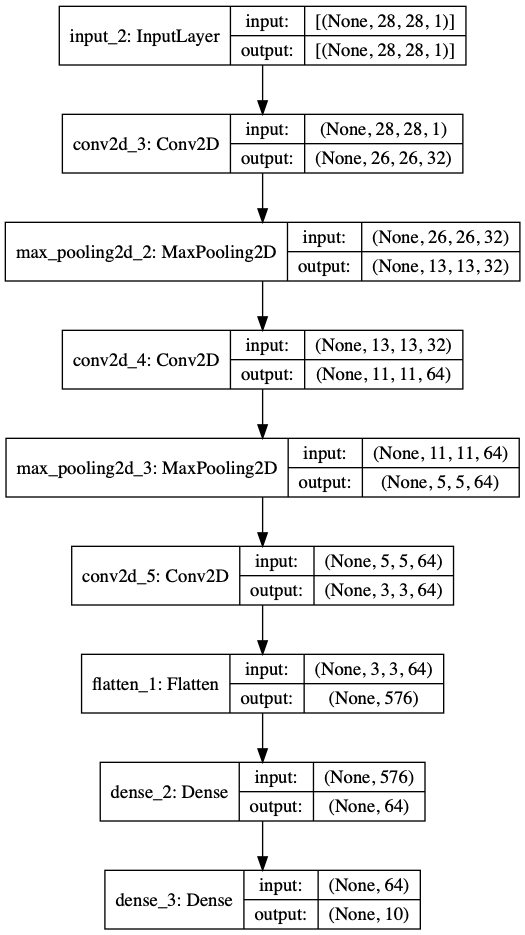

In [24]:
keras.utils.plot_model(model, show_shapes=True)

In [25]:
one_batch = None
for images, labels in train_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).take(1):
    one_batch = images

In [27]:
one_batch.shape

TensorShape([32, 28, 28, 1])

In [28]:
tp = model(one_batch)
tp.shape

TensorShape([32, 10])

# Train Model

In [29]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [31]:
tb = keras.callbacks.TensorBoard(log_dir="./mnist.tb", histogram_freq=1, update_freq="epoch")

model.fit(
    train_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE),
    validation_data=val_ds.batch(BATCH_SIZE),
    callbacks=[tb],
    epochs=3
)

Epoch 1/3
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0901 - accuracy: 0.9719 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
1500/1500 [==============================] - 26s 18ms/step - loss: 0.0463 - accuracy: 0.9856 - val_loss: 0.0490 - val_accuracy: 0.9855
Epoch 3/3
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.0469 - val_accuracy: 0.9867


# Evaluate the Model

In [32]:
loss, acc = model.evaluate(test_ds.batch(1000000))

      1/Unknown - 4s 4s/step - loss: 0.0439 - accuracy: 0.9876